# project 4

## Pre-processing the Data:

In [60]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm

In [61]:
df = pd.read_csv('/data/notebook_files/CVD_cleaned.csv')
# Binary columns transformation

df['Heart_Disease'] = df['Heart_Disease'].map({'Yes': 1, 'No': 0})
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0})
# Dropping columns we don't need

df.drop(columns=['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes',
                 'Arthritis', 'Smoking_History', 'Fruit_Consumption', 'Green_Vegetables_Consumption',
                 'FriedPotato_Consumption', 'Weight_(kg)', 'Height_(cm)'], inplace=True)
df.head()

,Heart_Disease,Sex,Age_Category,BMI,Alcohol_Consumption
0,0,1,70-74,14.54,0.0
1,1,1,70-74,28.29,0.0
2,0,1,60-64,33.47,4.0
3,1,0,75-79,28.73,0.0
4,0,0,80+,24.37,0.0


# Q1


Our research question:

**Is there a difference in mean BMI between males and females?**

In [62]:
# Setting a seed ensures that the random operations can be replicated for consistent results
np.random.seed(10101)

# Sampling 200 observations from the dataframe 'df' for initial analysis

observed_data_200 = df.sample(200)

# Removing the 200 sampled observations to avoid overlap in future samples
# This creates a new dataframe 'remaining_df' that excludes the previously sampled observations
remaining_df = df.drop(observed_data_200.index)

# Sampling 1000 additional observations from the remaining data for further analysis

past_data_1000 = remaining_df.sample(n=1000)

# Q2

In [63]:
x_title = 'BMI'
y_title = 'Sex'

male_num = 0
female_num = 1

In [64]:
# We define tau as the median of the BMI
tau = observed_data_200['BMI'].quantile(0.5)
print(f"tau is: {tau}")

tau is: 28.22


In [65]:
# Split the samples to males and females
observed_data_males_200 = observed_data_200[observed_data_200['Sex'] == 0]
observed_data_females_200 = observed_data_200[observed_data_200['Sex'] == 1]

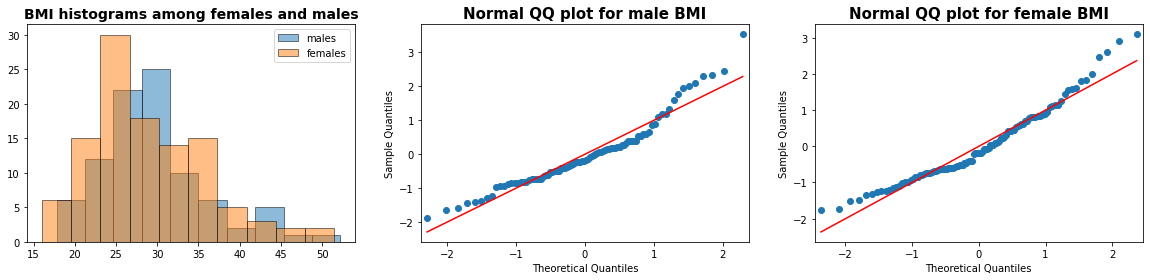

In [66]:
bins = 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
observed_data_males_200['BMI'].hist(edgecolor="black", grid=False, alpha=0.5,
                                    label="males", ax=ax1, bins=bins)
observed_data_females_200['BMI'].hist(edgecolor="black", grid=False, alpha=0.5,
                                      label="females", ax=ax1, bins=bins)
ax1.set_title("BMI histograms among females and males", fontweight="bold", fontsize=14)
ax1.legend()

qqplot(observed_data_males_200['BMI'].values, norm, fit=True, line="s", ax=ax2)
ax2.set_title("Normal QQ plot for male BMI", fontsize=15, fontweight="bold")

qqplot(observed_data_females_200['BMI'].values, norm, fit=True, line="s", ax=ax3)
ax3.set_title("Normal QQ plot for female BMI", fontsize=15, fontweight="bold")
plt.show()

we can see here, the values of the two categories (males and females) are distributed normally (although the unsuppressed group data is slightly skewed). because of that we can use a normal approximation to the bootstrap-based confidence interval.

## א

In [67]:

# We'll use these lists in section E
psi_array = []
RI_array = []

In [68]:
def get_probabilities_and_eta(observed_data_with_z):
    """
    Calculate probabilities and eta values for male and female categories within the dataset.
    """
    # Separating the dataset into male and female subsets based on the 'Sex' column
    observed_data_males = observed_data_with_z[observed_data_with_z['Sex'] == 0]
    observed_data_females = observed_data_with_z[observed_data_with_z['Sex'] == 1]

    # Calculating the probability of Z=1 for males
    p_males = len(observed_data_males[observed_data_males['Z'] == 1]) / len(observed_data_males)

    # Calculating the probability of Z=1 for females
    p_females = len(observed_data_females[observed_data_females['Z'] == 1]) / len(observed_data_females)

    # Computing the eta (𝜂) value for males, which is the logit of the probability
    eta_p_males = np.log(p_males / (1 - p_males))

    # Computing the eta (𝜂) value for females, similarly as the logit of the probability
    eta_p_females = np.log(p_females / (1 - p_females))

    return p_males, p_females, eta_p_males, eta_p_females

In [69]:
# Create a new binary variable 'Z' in the dataframe where 'Z' is 1 if 'BMI' is greater than tau, else 0
observed_data_200['Z'] = observed_data_200['BMI'] > tau
# Replace boolean values in 'Z' with integers (True to 1, False to 0)
observed_data_200.replace({'Z': {False: 0, True: 1}}, inplace=True)

# Calculate probabilities and eta values for both sexes using the defined function
p_males, p_females, eta_p_females, eta_p_males = get_probabilities_and_eta(observed_data_200)

# Calculate the psi estimator as the difference between eta values for females and males
psi_estimator = eta_p_females - eta_p_males

In [70]:
# Number of bootstrap samples
B = 400

# Initialization of the psi array
samples_psi_estimators = []

for _ in range(B):
    # Resample with replacement
    sample = observed_data_200.sample(200, replace=True)

    sample_p_males, sample_females, sample_eta_p_males, sample_eta_p_females = get_probabilities_and_eta(
        sample)
    # Estimates the psi of the sample and adding it to the array
    sample_psi = sample_eta_p_males - sample_eta_p_females

    samples_psi_estimators.append(sample_psi)

# Set the confidence level
confidence_level = 0.95

# Calculate the critical value based on the confidence level
# For an asymptotic normal distribution, we can use the z-score
z_critical = stats.norm.ppf(1 - (1 - confidence_level) / 2)  # == 0.975

# Calculate the standard deviation of the psi across bootstrap samples
bootstrap_sd = np.std(samples_psi_estimators, axis=0)
 
# Calculate the lower and upper bounds of the confidence interval
RI = [psi_estimator - z_critical * bootstrap_sd, psi_estimator + z_critical * bootstrap_sd]

# For future use in section e
psi_array.append(psi_estimator)
RI_array.append(RI)

print(f"The estimator for psi is: {psi_estimator}")
print(f"The confidence interval to psi is: {RI}")

The estimator for psi is: 0.24273068458951466
The confidence interval to psi is: [-0.3305383257323137, 0.8159996949113429]


## ב 

In practice, the expected matching method when: 
$ S $ = the number of claims submitted by a sample surfer 
$ n $ = the total number of claims

$$
\frac{2}{n+2} E_{\pi}[p] + \frac{n}{n+2} \hat{p}^{MLE} = \frac{1}{n+2} + \frac{S}{n+2} = \frac{S+1}{n+2}
$$

In [71]:

# Filtering data for males and females based on the 'Sex' column
observed_data_males = observed_data_200[observed_data_200['Sex'] == 0]
observed_data_females = observed_data_200[observed_data_200['Sex'] == 1]

# Calculating the probability of Z=1 for males
# Adjust the count of males with Z=1 by adding 1 for Laplace smoothing
z_1_males_num_S = len(observed_data_males[observed_data_males['Z'] == 1])
# Total number of males in the dataset
males_num_n = len(observed_data_males)
# Calculate the probability with Laplace smoothing
p_males = (z_1_males_num_S + 1) / (males_num_n + 2)

# Calculating the probability of Z=1 for females
# Adjust the count of females with Z=1 by adding 1 for Laplace smoothing
z_1_females_num_S = len(observed_data_females[observed_data_females['Z'] == 1])
# Total number of females in the dataset
females_num_n = len(observed_data_females)
# Calculate the probability with Laplace smoothing
p_females = (z_1_females_num_S + 1) / (females_num_n + 2)

# Calculating the log-odds (eta) for males and females
eta_p_males = np.log(p_males / (1 - p_males))
eta_p_females = np.log(p_females / (1 - p_females))

# Calculating the difference in log-odds (psi) between males and females
psi = eta_p_males - eta_p_females

$p_1 | X_m \propto \text{Beta}(S_x + 1, m - S_x + 1)$

$p_2 | Y_n \propto \text{Beta}(S_y + 1, n - S_y + 1)$

In [72]:
# Setting the number of bootstrap samples
B = 400

# Initializing the list to store psi values for each bootstrap sample
samples_psi = []

for b in range(B):
    # Generating bootstrap samples for male and female probabilities using Beta distribution
    # The parameters are derived from observed counts with a Bayesian perspective
    sample_p_males = stats.beta.rvs(z_1_males_num_S + 1, males_num_n - z_1_males_num_S + 1, size=1)
    sample_p_females = stats.beta.rvs(z_1_females_num_S + 1, females_num_n - z_1_females_num_S + 1, size=1)
    
    # Computing the log-odds (eta) for the bootstrap probabilities for males and females
    sample_eta_p_males = np.log(sample_p_males / (1 - sample_p_males))
    sample_eta_p_females = np.log(sample_p_females / (1 - sample_p_females))

    # Calculating the difference in log-odds (psi) for the sample and storing it
    sample_psi = sample_eta_p_males - sample_eta_p_females
    samples_psi.append(sample_psi[0])

# Calculating the 95% reliability interval for psi
RI = [np.quantile(samples_psi, 0.025), np.quantile(samples_psi, 0.975)]

# Storing psi and its reliability interval for future reference (e.g., in section e)
psi_array.append(psi)
RI_array.append(RI)

# Displaying the estimated psi and its reliability interval
print(f"The estimated value for psi is: {psi}")
print(f"The 95% reliability interval for psi is: {RI}")

The estimated value for psi is: 0.2378657127706621
The 95% reliability interval for psi is: [-0.3328949542945969, 0.7556958757080245]


## ג

The likelihood function for the parameter \( p \) given the data \( x^n \) is proportional to the prior times the likelihood of \( p \), which can be written as:

$$
f(p|x^n) \propto \pi(p) L_n(p) = \frac{1}{\sqrt{p(1-p)}} \cdot p^S(1-p)^{n-S} = p^{S-\frac{1}{2}}(1-p)^{n-S-\frac{1}{2}}
$$

Which is proprstional to a Beta distribution:

$$
= p^{(S+\frac{1}{2})-1}(1-p)^{(n-S+\frac{1}{2})-1} \propto \text{Beta}\left( S + \frac{1}{2}, n - S + \frac{1}{2}\right)
$$

In [73]:
# Number of bootstrap samples
B = 400

# Initialization of the psi array
samples_psi = []

for b in range(B):
    # Estimates the probability for each category of the sample
    sample_p_males = stats.beta.rvs(z_1_males_num_S + 0.5, males_num_n - z_1_males_num_S + 0.5, size=1)
    sample_p_females = stats.beta.rvs(z_1_females_num_S + 0.5, females_num_n - z_1_females_num_S + 0.5, size=1)

    # Estimates the eta for each probability of the sample
    sample_eta_p_males = np.log(sample_p_males / (1 - sample_p_males))
    sample_eta_p_females = np.log(sample_p_females/(1-sample_p_females))

    # Estimates the psi of the sample and adding it to the array
    sample_psi = sample_eta_p_males - sample_eta_p_females
    samples_psi.append(sample_psi)

# Estimates the psi 
psi = np.mean(samples_psi)
    
# Reliability interval    
RI = [np.quantile(samples_psi, 0.025), np.quantile(samples_psi, 0.975)]

# For future use in section e
psi_array.append(psi)
RI_array.append(RI)

print(f"The estimator for psi is: {psi}")
print(f"The reliability interval is: {RI}")

The estimator for psi is: 0.2378444005156918
The reliability interval is: [-0.2673117632258802, 0.7725383123723466]


## ד

We assume that for each gender group $j$, the prior distribution for $p_i$ is a Beta distribution: $p_i \sim Beta(\alpha_j, \beta_j)$, where $\alpha_j = 1 + \sum_{1}^{n} I(z = 1)_j$ and $\beta_j = 1 + n_j - \sum_{1}^{n} I(z = 1)_j$. 

Given the data, $Z = 1$ occurs $k_j$ times out of $n_j$ observations in group $j$. The likelihood is $p_i^{k_j} (1 - p_i)^{n_j - k_j}$.

By Bayes' theorem:

$$
\text{Posterior} \propto \text{Likelihood} \times \text{Prior} = p_i^{k_j} (1 - p_i)^{n_j - k_j} \times p_i^{\alpha_j - 1} (1 - p_i)^{\beta_j - 1}
$$

Combining exponents:

$$
\text{Posterior} \propto p_i^{k_j + \alpha_j - 1} (1 - p_i)^{n_j - k_j + \beta_j - 1}
$$

Hence, the posterior is $Beta(k_j + \alpha_j, n_j - k_j + \beta_j)$.

In [74]:
# Define a new binary variable Z based on tau 
past_data_1000['Z'] =  past_data_1000['BMI'] > tau 
past_data_1000.replace({'Z': {False : 0, True : 1}}, inplace=True)

# Split the sample by the category
past_data_males = past_data_1000[past_data_1000['Sex'] == 0]
past_data_females = past_data_1000[past_data_1000['Sex'] == 1]

# Calculate the number of occurrences in the sample for which Z=1.
z_1_males_num = len(past_data_males[past_data_males['Z'] == 1])
z_1_females_num = len(past_data_females[past_data_females['Z'] == 1])

# Calculate the number of all the occurrences in the sample.
males_num = len(past_data_males)
females_num = len(past_data_females)

# Calculate the alfa and beta for each category
alfa_females = z_1_females_num + 1
alfa_males = z_1_males_num + 1
beta_females = females_num - z_1_females_num + 1
beta_males = males_num - z_1_males_num + 1

print(f"p1 (males) prior distribution: Beta({alfa_males}, {beta_males})")
print(f"p1 (males) posterior distribution: Beta({alfa_males + z_1_males_num}, {beta_males + males_num - z_1_males_num})")

print(f"p2 (females) prior distribution: Beta({alfa_females}, {beta_females})")
print(f"p2 (females) posterior distribution: Beta({alfa_females + z_1_females_num}, {beta_females + females_num - z_1_females_num})")

p1 (males) prior distribution: Beta(219, 251)
p1 (males) posterior distribution: Beta(437, 501)
p2 (females) prior distribution: Beta(233, 301)
p2 (females) posterior distribution: Beta(465, 601)


In [75]:
# Number of bootstrap samples
B = 400

# Initialization of the psi array
samples_psi = []

for b in range(B):
    # Generating sample probabilities for each gender using a beta distribution
    sample_p_females = stats.beta.rvs(alfa_females + z_1_females_num, beta_females + females_num - z_1_females_num, size=1)
    sample_p_males = stats.beta.rvs(alfa_males + z_1_males_num, beta_males + males_num - z_1_males_num, size=1)
    
    # Calculating eta values by applying a logarithmic transformation to the probability ratios
    sample_eta_p_males = np.log(sample_p_males / (1 - sample_p_males))
    sample_eta_p_females = np.log(sample_p_females / (1 - sample_p_females))

    # Computing the difference in eta values to estimate psi and appending it directly to the list
    samples_psi.append(sample_eta_p_males - sample_eta_p_females)

# Calculating the mean of psi values directly without intermediate variable assignment
psi = np.mean(samples_psi)

# Computing the reliability interval directly within the print statement
RI = [np.quantile(samples_psi, 0.025), np.quantile(samples_psi, 0.975)]

# Storing psi and RI values for future reference
psi_array.append(psi)
RI_array.append(RI)

# Printing the estimated psi and reliability interval
print(f"The estimated psi value is: {psi}")
print(f"The calculated reliability interval is: {RI}")

The estimated psi value is: 0.12447574909206828
The calculated reliability interval is: [-0.029839863418218943, 0.3243868145928361]


## ה

Psi value for a interval: 0.24273068458951466
Psi value for b interval: 0.2378657127706621
Psi value for c interval: 0.2378444005156918
Psi value for d interval: 0.12447574909206828


<ipython-input-76-85cea32ac756>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(interval_value, (idx, idx), 'ro-', color="green")


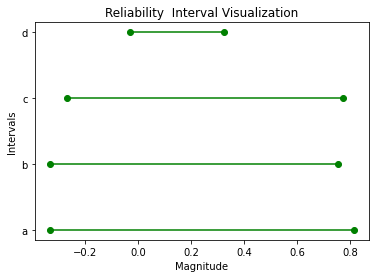

In [76]:
# Setting up interval boundaries with a dictionary structure
interval_definitions = {
    'a': RI_array[0],
    'b': RI_array[1],
    'c': RI_array[2],
    'd': RI_array[3]
}

# Utilizing enumerate for simultaneous indexing and retrieval in the loop
for idx, (section, interval_value) in enumerate(interval_definitions.items()):
    # Directly plotting intervals with red circles and black connecting lines
    plt.plot(interval_value, (idx, idx), 'ro-', color="green")
    
    # Displaying the psi value corresponding to each interval
    print(f"Psi value for {section} interval: {psi_array[idx]}")

# Adjusting y-axis ticks and labels to match interval names
plt.yticks(range(len(interval_definitions)), interval_definitions.keys())

# Labeling x-axis and y-axis for clarity
plt.xlabel("Magnitude")
plt.ylabel("Intervals")

# Giving the plot a descriptive title
plt.title("Reliability  Interval Visualization")

# Rendering the plot
plt.show()


As we can see above, the smallest reliability interval was found in section D. This result is expected because, in section D, we relied on past data that had a larger number of observations. Generally, more data points contribute to a more stable and accurate estimate, which in turn reduces variance. A lower variance is directly associated with a narrower confidence interval, meaning our estimate is more precise.We should also note that the lengths of the reliability intervals of sections A to C were quite similar, suggesting consistency across our analytical approaches. This consistency is a good indicator that our methods are robust, providing reliable results regardless of the technique applied.